In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [2]:
Japan = pd.read_csv('JPN.csv')
print(Japan.info())     # Overview of column types
print(Japan.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          40000 non-null  object
 1   CURR_AGE    40000 non-null  int64 
 2   GENDER      40000 non-null  object
 3   ANN_INCOME  40000 non-null  object
 4   AGE_CAR     40000 non-null  int64 
 5   PURCHASE    40000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.8+ MB
None
ID            0
CURR_AGE      0
GENDER        0
ANN_INCOME    0
AGE_CAR       0
PURCHASE      0
dtype: int64


In [3]:
Japan['ANN_INCOME'] = Japan['ANN_INCOME'].str.replace(',', '').astype(float)

In [4]:
Japan['GENDER'] = Japan['GENDER'].map({'M': 0, 'F': 1})

In [5]:
print(Japan.head())     # See first few rows
print(Japan.describe()) # For numerical stats

           ID  CURR_AGE  GENDER  ANN_INCOME  AGE_CAR  PURCHASE
0  00001Q15YJ        50       0    445344.0      439         0
1  00003I71CQ        35       0    107634.0      283         0
2  00003N47FS        59       1    502787.0      390         1
3  00005H41DE        43       0    585664.0      475         0
4  00007E17UM        39       1    705723.0      497         1
          CURR_AGE        GENDER     ANN_INCOME       AGE_CAR      PURCHASE
count  40000.00000  40000.000000   40000.000000  40000.000000  40000.000000
mean      44.99745      0.442875  359398.878225    359.080250      0.575775
std       11.82008      0.496732  175109.260472    203.063724      0.494231
min       25.00000      0.000000   70089.000000      1.000000      0.000000
25%       35.00000      0.000000  219766.000000    235.000000      0.000000
50%       45.00000      0.000000  337657.000000    331.000000      1.000000
75%       55.00000      1.000000  464260.750000    444.000000      1.000000
max       65.0

In [6]:
India = pd.read_csv("IN.csv")
print(India.info())     # Overview of column types
print(India.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          70000 non-null  object
 1   CURR_AGE    70000 non-null  int64 
 2   GENDER      70000 non-null  object
 3   ANN_INCOME  70000 non-null  object
 4   DT_MAINT    70000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.7+ MB
None
ID            0
CURR_AGE      0
GENDER        0
ANN_INCOME    0
DT_MAINT      0
dtype: int64


In [7]:
India['ANN_INCOME'] = India['ANN_INCOME'].str.replace(',', '').astype(float)
India['GENDER'] = India['GENDER'].map({'M': 0, 'F': 1})

In [8]:
#As age car is not mentioned
# Step 1: Convert DT_MAINT to datetime
India['DT_MAINT'] = pd.to_datetime(India['DT_MAINT'], errors='coerce')

# Step 2: Define reference date
ref_date = pd.to_datetime('2019-07-01')

# Step 3: Calculate difference in days
India['AGE_CAR'] = (ref_date - India['DT_MAINT']).dt.days.round(2)

In [9]:
India.drop('DT_MAINT', axis=1, inplace=True)

In [10]:
print(India.head())     # See first few rows
print(India.describe()) # For numerical stats

           ID  CURR_AGE  GENDER  ANN_INCOME  AGE_CAR
0  20710B05XL        54       0   1425390.0      437
1  89602T51HX        47       0   1678954.0      388
2  70190Z52IP        60       0    931624.0      700
3  25623V15MU        55       1   1106320.0      700
4  36230I68CE        32       1    748465.0      155
           CURR_AGE        GENDER    ANN_INCOME       AGE_CAR
count  70000.000000  70000.000000  7.000000e+04  70000.000000
mean      44.995314      0.499586  1.148679e+06    367.326057
std       11.822122      0.500003  3.994505e+05    241.999792
min       25.000000      0.000000  3.000330e+05      1.000000
25%       35.000000      0.000000  8.568238e+05    189.000000
50%       45.000000      0.000000  1.125152e+06    340.000000
75%       55.000000      1.000000  1.438676e+06    473.000000
max       65.000000      1.000000  1.999989e+06   1020.000000


In [11]:
def assign_segment(days):
    if pd.isnull(days):
        return None
    elif days < 200:
        return 1
    elif 200 <= days <= 360:
        return 2
    elif 360 < days <= 500:
        return 3
    else:
        return 4

Japan['AGE_CAR_SEGMENT'] = Japan['AGE_CAR'].apply(assign_segment)
India['AGE_CAR_SEGMENT'] = India['AGE_CAR'].apply(assign_segment)

In [12]:
print(Japan['AGE_CAR_SEGMENT'].value_counts(dropna=False).sort_index())
print(India['AGE_CAR_SEGMENT'].value_counts(dropna=False).sort_index())

AGE_CAR_SEGMENT
1     6459
2    16545
3    11697
4     5299
Name: count, dtype: int64
AGE_CAR_SEGMENT
1    18496
2    18994
3    18691
4    13819
Name: count, dtype: int64


In [13]:
#Model :
#1.Logistic Regression was selected as a baseline model due to its interpretability and suitability for binary classification.
#2.AGE_CAR was bucketed into categorical segments to reflect its non-linear impact on purchase behavior.
#3.One-Hot Encoding was used to convert categorical data for modeling.

# Select features
features = ['CURR_AGE', 'GENDER', 'ANN_INCOME', 'AGE_CAR_SEGMENT']
target = 'PURCHASE'

# One-Hot Encode 'GENDER' and 'AGE_CAR_SEGMENT'
encoder = OneHotEncoder(drop='first', sparse=False)
Japan_encoded = pd.DataFrame(encoder.fit_transform(Japan[['GENDER', 'AGE_CAR_SEGMENT']]))
Japan_encoded.columns = encoder.get_feature_names_out(['GENDER', 'AGE_CAR_SEGMENT'])
Japan_final = pd.concat([Japan[features], Japan_encoded], axis=1).drop(['GENDER', 'AGE_CAR_SEGMENT'], axis=1)
Japan_final[target] = Japan[target]

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
X_Japan = Japan_final.drop('PURCHASE', axis=1)
Y_Japan = Japan_final['PURCHASE'].round(1)

X_Japan_train, X_Japan_test, Y_Japan_train, Y_Japan_test = train_test_split(
    X_Japan, Y_Japan, stratify=Y_Japan, test_size=0.3, random_state=42
)

In [15]:
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=10,  # only try 10 combinations
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_Japan_train, Y_Japan_train)
model_japan = random_search.best_estimator_

In [16]:
Y_Japan_pred = model_japan.predict(X_Japan_test)
Y_Japan_prob = model_japan.predict_proba(X_Japan_test)[:, 1]
print("Accuracy:", accuracy_score(Y_Japan_test, Y_Japan_pred))
print("ROC-AUC Score:", roc_auc_score(Y_Japan_test, Y_Japan_prob))
print(confusion_matrix(Y_Japan_test, Y_Japan_pred))
print(classification_report(Y_Japan_test, Y_Japan_pred))

Accuracy: 0.6971666666666667
ROC-AUC Score: 0.7789573374370792
[[3301 1790]
 [1844 5065]]
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      5091
           1       0.74      0.73      0.74      6909

    accuracy                           0.70     12000
   macro avg       0.69      0.69      0.69     12000
weighted avg       0.70      0.70      0.70     12000



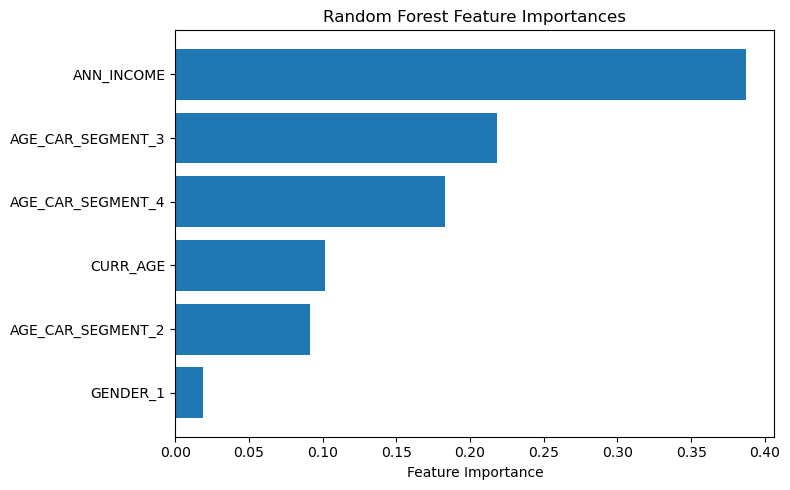

In [17]:
# Feature importance
importances = model_japan.feature_importances_
feature_names = X_Japan_train.columns

# Create dataframe for sorting and visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [18]:
print(India.columns.tolist())
# 1. Select only relevant columns used in model training
India_cleaned = India[['CURR_AGE', 'GENDER', 'ANN_INCOME', 'AGE_CAR', 'AGE_CAR_SEGMENT']].copy()

# 2. Encode categorical columns using the same encoder as used on Japan dataset
India_encoded = pd.DataFrame(
    encoder.transform(India_cleaned[['GENDER', 'AGE_CAR_SEGMENT']]),
    columns=encoder.get_feature_names_out(['GENDER', 'AGE_CAR_SEGMENT'])
)

# 3. Combine numerical and encoded categorical features
India_numerical = India_cleaned.drop(['GENDER', 'AGE_CAR_SEGMENT'], axis=1)
India_final_rf = pd.concat([India_numerical.reset_index(drop=True), India_encoded.reset_index(drop=True)], axis=1)

# 4. Align columns with what Random Forest model was trained on
India_final_rf = India_final_rf[model_japan.feature_names_in_]

# 5. Predict purchase probabilities and class
India['PURCHASE_PROB_RF'] = model_japan.predict_proba(India_final_rf)[:, 1].round(2)
India['PREDICTED_PURCHASE_RF'] = (India['PURCHASE_PROB_RF'] >= 0.5).astype(int)

# 6. Count potential buyers
potential_customers_rf = India['PREDICTED_PURCHASE_RF'].sum()
print("✅ Potential customers in India (Random Forest):", potential_customers_rf)


['ID', 'CURR_AGE', 'GENDER', 'ANN_INCOME', 'AGE_CAR', 'AGE_CAR_SEGMENT']
✅ Potential customers in India (Random Forest): 52369


In [19]:
# Evaluating the Model
print("Accuracy:", accuracy_score(Y_Japan_test, Y_Japan_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_Japan_test, Y_Japan_pred))
print("Classification Report:\n", classification_report(Y_Japan_test, Y_Japan_pred))
print("ROC AUC Score:", roc_auc_score(Y_Japan_test, model_japan.predict_proba(X_Japan_test)[:, 1]))

Accuracy: 0.6971666666666667
Confusion Matrix:
 [[3301 1790]
 [1844 5065]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.64      5091
           1       0.74      0.73      0.74      6909

    accuracy                           0.70     12000
   macro avg       0.69      0.69      0.69     12000
weighted avg       0.70      0.70      0.70     12000

ROC AUC Score: 0.7789573374370792


In [ ]:
Japan.to_csv("cleaned_japan.csv", index=False)
India.to_csv("cleaned_india_with_preds.csv", index=False)
# Combining for Tableau
Japan['COUNTRY'] = 'JAPAN'
India['COUNTRY'] = 'INDIA'

# 1. Combine datasets
Combined = pd.concat([Japan, India], ignore_index=True)

# 2. One-hot encode
Combined_encoded = pd.get_dummies(Combined, drop_first=True)

# 3. Align with model's expected features
expected_cols = model_japan.feature_names_in_

for col in expected_cols:
    if col not in Combined_encoded.columns:
        Combined_encoded[col] = 0

Combined_encoded = Combined_encoded[expected_cols]

# 4. Predict
Combined['PREDICTED_PURCHASE'] = model_japan.predict(Combined_encoded)
Combined['PREDICTED_PURCHASE'] = Combined['PREDICTED_PURCHASE'].astype(int)

# Save to CSV
Combined.to_csv("Combined_Predictions.csv", index=False)
